In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf
from math import ceil
import numpy as np
from scipy import linalg
import math
import pylab as pl
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime
import pickle as pkl
import time
import requests

# Data Preprocessing

In [3]:
df = pd.read_csv("ydata", header=None) #original data
data = pd.DataFrame(df.iloc[:, 0].apply(lambda y: y.split("|")[0]))
data[["timestamp", "id", "click"]] = data[0].str.split(expand=True)
data = data.drop([0], axis=1)

In [4]:
data

,timestamp,id,click
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0
...,...,...,...
1607520,1317599692,id-566439,0
1607521,1317599692,id-566825,0
1607522,1317599693,id-563643,0
1607523,1317599694,id-566431,0


In [45]:
id_list = pd.DataFrame(data.groupby('id')['click'].count()).sort_values('click', ascending=False).head(6).index
id_list

Index(['id-564418', 'id-563846', 'id-563643', 'id-565822', 'id-555224',
       'id-559855'],
      dtype='object', name='id')

In [47]:
Click2CTR(data, id='id-563846', start=start, end=end)

,date,CTR
25246,2011-10-02 12:00:00,0.049210
25247,2011-10-02 12:00:01,0.049787
25248,2011-10-02 12:00:01,0.049757
25249,2011-10-02 12:00:02,0.049757
25250,2011-10-02 12:00:07,0.049787
...,...,...
46305,2011-10-02 17:59:58,0.034783
46306,2011-10-02 17:59:58,0.034773
46307,2011-10-02 17:59:59,0.034773
46308,2011-10-02 17:59:59,0.034764


In [39]:
test = Click2CTR(data, 'id-563846')
test[(test["date"] <= "2011-10-02 18:00:00") & (test["date"] >= "2011-10-02 12:00:00")]

,date,CTR
25246,2011-10-02 12:00:00,0.049210
25247,2011-10-02 12:00:01,0.049787
25248,2011-10-02 12:00:01,0.049757
25249,2011-10-02 12:00:02,0.049757
25250,2011-10-02 12:00:07,0.049787
...,...,...
46305,2011-10-02 17:59:58,0.034783
46306,2011-10-02 17:59:58,0.034773
46307,2011-10-02 17:59:59,0.034773
46308,2011-10-02 17:59:59,0.034764


Text(0.5, 1.0, 'CTR curves of six contents')

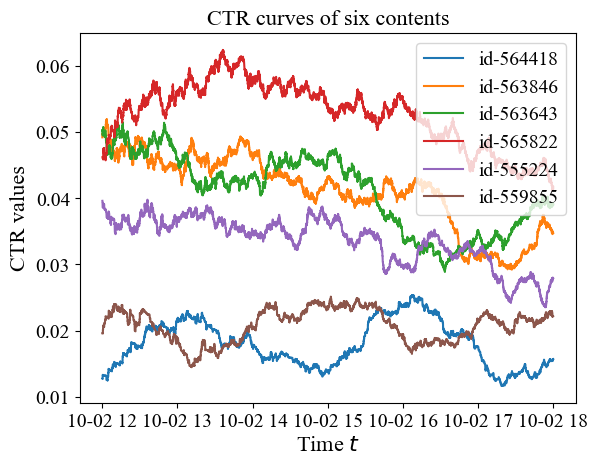

In [52]:
# Use Times New Roman font for LaTeX rendering
from matplotlib import rc
rc('font', family='Times New Roman')
start = "2011-10-02 12:00:00"
end = "2011-10-02 18:00:00"

for id in id_list:
    plt.plot(Click2CTR(data, id, start=start, end=end), label=id)

plt.legend(fontsize=14)
plt.xlabel('Time $t$', fontsize=16)
plt.ylabel('CTR values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("CTR curves of six contents", fontsize=16)

In [4]:
# Top 5 contents with the highest clicks
pd.DataFrame(data.groupby('id')['click'].count()).sort_values('click', ascending=False).head(20)

,click
id,
id-564418,70324
id-563846,70323
id-563643,70320
id-565822,69912
id-555224,55820
id-559855,54812
id-565515,54793
id-560290,54454
id-565648,54096


In [5]:
pd.DataFrame(data.groupby('id')['click'].count()).sort_values('click', ascending=False).head(20).index

Index(['id-564418', 'id-563846', 'id-563643', 'id-565822', 'id-555224',
       'id-559855', 'id-565515', 'id-560290', 'id-565648', 'id-555528',
       'id-563582', 'id-565533', 'id-565479', 'id-566022', 'id-563115',
       'id-560518', 'id-565930', 'id-565589', 'id-566013', 'id-564335'],
      dtype='object', name='id')

In [48]:
# Convert click data to CTR data
def Click2CTR(data, id, start, end):
    sample = data[data["id"] == id].copy()
    sample['date'] = pd.to_datetime(sample['timestamp'], unit='s') # convert timestamp to datetime
    date_click = sample[['date', 'click']].set_index('date') # timeseries click data
    date_CTR = pd.DataFrame(date_click.rolling('1h').mean()).rename(columns={'click':'CTR'}).reset_index() # convert click data to CTR data (window size = 1h)
    date_CTR = date_CTR[(date_CTR["date"] <= end) & (date_CTR["date"] >= start)]
    CTR = date_CTR.set_index("date")
    return CTR

# Local Linear Regression

In [8]:
def LowessSmoother(data, f, iter, start, end, scale):
    """
    Function signature:
    lowess(x, y, f=2./3., iter=3, scale=10) -> ypred
    
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    
    Input:
    A dataframe of two columns: datetime x[i] (0<=i<=n-1) and CTR y[i] (0<=i<=n-1)
    where n is the number of rows (time horizon).
    
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. 
    
    The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    
    Start and end are the timestamps of the starting time and the ending time.
    
    The time step of the output data is given by 1/scale.
    
    Output:
    The function returns x, y, ypred, where x and y are the arrays of time and CTR value
    of the input data, and ypred is an array of smoothed CTR values of y.
    
    The length of ypred is (end-start)*scale. 
    
    The subarray [ypred[x[i]*scale], ..., ypred[x[i+1]*scale]-1] contains rewards 
    (smoothed CTR values) in the time interval [x[i], x[i+1]) with a time step of delta.
    
    The entry ypred[x[i]*scale+k] represents the reward at time x[i]+k/scale.
    
    """
    
    x = (data.reset_index()['date'].apply(lambda x: x.to_pydatetime().timestamp()-start)).astype(int).to_numpy() # convert timestamp to time (start time = 0)
    y = data.CTR.to_numpy()
    
    # estimation of y
    n = len(x) # length of x
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    beta = np.zeros((n, 2))
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta[i] = linalg.solve(A, b)
            yest[i] = beta[i][0] + beta[i][1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2
        
    
    # interpolation of y
    x = np.append(x, end-start)
    y = np.append(y, y[-1])
    x = np.insert(x, 0, 0)
    y = np.insert(y, 0, y[0])
    beta = np.insert(beta, 0, beta[0], axis=0)
    ypred = np.zeros(scale*(end-start))
    for i in range(n+1):
        ypred[scale*x[i]:scale*x[i+1]] = beta[i][0] + beta[i][1] * np.arange(x[i], x[i+1], 1/scale)

    return ypred
#     return yest

In [ ]:
num_arms = 20
id_list = pd.DataFrame(data.groupby('id')['click'].count()).sort_values('click', ascending=False).head(num_arms).index
CTR_data = np.empty((0, 864000000), dtype=float)
start = int(datetime(2011, 10, 2, 12, 0, 0).timestamp())  # '2011-10-02 12:00:00'
end = int(datetime(2011, 10, 2, 18, 0, 0).timestamp())  #'2011-10-02 18:00:00'
for id in id_list:
    CTR = Click2CTR(id)
    ypred = LowessSmoother(CTR, f=0.25, iter=3, start = start, end = end, scale=4000)
    CTR_data = np.append(CTR_data, [ypred], axis=0)

In [ ]:
dump_start = time.time()
pkl.dump(CTR_data, open("CTR_data.pkl","wb"))
dump_end = time.time()
dump_end - dump_start